# Introduction to Quantum Computing

## Overview 

This notebook provides an introduction to some basic quantum computing concepts and how to program a quantum computer using quantum circuits.

We recommend you have some knowledge of:
* Python programming: language, importing libraries, using functions.
* basic quantum computing concepts: qubits, quantum processes like superposition, interference and entanglement.

### Learning Objects 

After using this notebook you should have an understanding of 

* What are *qubits* and why they are different from classical binary bits.
* What is *superposition* and how it could be used to solve a problem.
* What is *interference & entanglement* and how it could be used to solve a problem.
* What are *quantum circuits* and how they relate to solving a problem. 


## Python Refresher 

Python is an interpreted, high-level, and general-purpose programming language created by Guido van Rossum and first released in 1991. It emphasizes readability and simplicity, making it ideal for both beginners and experienced developers. Python supports multiple programming paradigms, including procedural, object-oriented, and functional programming. It's widely used for web development, data analysis, artificial intelligence, scientific computing, and more due to its extensive standard library and community support. 


### Examples

We do not provide an introduction to the Python programming lanuage but quickly refresh some relevant examples below.

1. How to print hello
   ```python
   print("Hello, World!")
   ```
2. How to declare some variables and doing some mathematical operations
   ```python
   a = 5
   b = 3
   sum = a + b
   print("Sum:", sum)
   ```
3. How to define a function
   ```python
   def greet(name):
     return f"Hello, {name}!"
   print(greet("Alice"))
   ```
4. How to import a library
   ```python
   # import the numerical library of python
   import numpy as np 
   # create an array of ones of size 5, ie: [1,1,1,1,1]
   x = np.ones(5)
   print(x)
   ```


In [10]:
# here lets import and set some python/jupyter preliminaries
%matplotlib inline

# generic plotting library 
import matplotlib
import matplotlib.pyplot as plt
matplotlib.logging.getLogger('matplotlib.font_manager').disabled = True

# penny lane quantum computing library
import pennylane as qml
from pennylane import numpy as np
qml.drawer.use_style('sketch')

# quatnum music visualisation 
import qmuvi
from qiskit import QuantumCircuit

# import interactive widgets
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from IPython.display import display, Markdown, Latex

In [82]:
# some helper function definitions

def PlotPennyLaneHisto(results, plottitle : str = ''):
    with plt.xkcd():
    # Based on "Stove Ownership" from XKCD by Randall Munroe
    # https://xkcd.com/418/

        fig = plt.figure()
        ax = fig.add_axes((0.1, 0.2, 0.8, 0.7))
        ax.spines[['top', 'right']].set_visible(False)
        labels = [rf'$|{k}>$' for k in results.keys()]
        xvals = np.arange(len(results.keys()))
        yvals = [results[k] for k in results.keys()]
        ax.bar(labels, yvals, facecolor='DarkOrange', edgecolor='Gold', linewidth=4)
        ax.tick_params(axis='x', labelrotation=80)
        ax.set_xlabel('Qubit States')
        ax.set_ylabel('Count')
        ax.set_title(plottitle)
        fig.show()

def MakeCircuit(num_qubits : int = 1, 
                add_H : bool = True, 
                add_CNOT : bool = True,
                hqubits : list = None,
               ):
    """
    Construct a circuit with a certain number of qubits
    """
    qubits = [f'|{i}>' for i in range(1,num_qubits+1)]
    if hqubits == None:
        hqubits = qubits
    else:
        hqubits = [qubits[q] for q in hqubits]
    # circuit     
    dev = qml.device("default.qubit", wires=qubits)
    @qml.qnode(dev)
    def circuit(qubits, add_H, add_CNOT, hqubits):
        if add_H: 
            for q in hqubits:
                qml.Hadamard(wires=q)
        if add_CNOT and len(qubits)>1: 
            for q in qubits[1:]:
                qml.CNOT([qubits[0],q])
        return qml.counts(all_outcomes=True)
    # plotting circuit
    fig, ax = qml.draw_mpl(circuit, show_all_wires=True)(qubits, add_H, add_CNOT, hqubits)
    fig.show()


def MakeAndRunCircuit(num_shots :int = 100, 
                      num_qubits : int = 1, 
                      add_H : bool = True, 
                      add_CNOT : bool = True, 
                      hqubits : list = None
                     ):
    """
    Construct a circuit with a certain number of qubits and run a certain number of shots
    """
    max_nshots = 10000
    max_nqubits = 30
    qubits = [f'|{i}>' for i in range(1,num_qubits+1)]
    if hqubits == None:
        hqubits = qubits
    else:
        hqubits = [qubits[q] for q in hqubits]

    dev = qml.device("default.qubit", wires=qubits)
    @qml.qnode(dev)
    def circuit(qubits, add_H, add_CNOT, hqubits):
        if add_H: 
            for q in hqubits:
                qml.Hadamard(wires=q)
        if add_CNOT and len(qubits)>1: 
            for q in qubits[1:]:
                qml.CNOT([qubits[0],q])
        return qml.counts(all_outcomes=True)

    fig, ax = qml.draw_mpl(circuit, show_all_wires=True)(qubits, add_H, add_CNOT, hqubits)
    fig.show()
    if (num_shots > max_nshots) or (num_qubits > max_nqubits):
        display(Markdown('# WARNING'))
        display(Markdown('You have asked to simulate either too many shots (measurements) or too many qubits. ***NOT SIMULATING***'))
        display(Markdown(f'* *Number of measurements should be $<{max_nshots}$ and requested:* {num_shots}'))
        display(Markdown(f'* *Number of qubits should be $<{max_nqubits}$ and requested:* {num_qubits}. This would require {2**(num_qubits-30)} GB of memory and take a long time to simulate'))
    else:
        # now you try running more shots by running the circuit again. 
        results = circuit(qubits, add_H, add_CNOT, hqubits, shots=num_shots)
        # here plot the results
        PlotPennyLaneHisto(results, f'Measurment results from {num_shots} measurements')

## Qubits

#### PJE add figure of bit vs qubit

Before discussing a quantum bit, so-called *qubit*, it is important to understand how *classical* computers like the one running this notebook operate and what a classical binary bit is. 

### Classical Bit 
A bit is a digital representation of either 0 *or* 1. This simple bit can be used to represent a number of numbers (see [https://en.wikipedia.org/wiki/Binary_number]). The binary representation of numbers such as 12 can be done by combining several bits together. In the case of 4 bits, you can view the combination as a sum where each bit represents a power of 2: the first bit being indicating an on/off of $2^0=1$; second bit $2^1=2$; third $2^2=4$; fourth $2^3=8$. 

#### Examples 
* 0000: This represents the decimal number 0 as you have $0\times2^{0}+0\times2^{1}+0\times2^{2}+0\times2^{3}$.
* 0001: This represents the decimal number 1.
* 0010: This represents the decimal number 2.
* 0100: This represents the decimal number 4.
* 1010: This represents the decimal number 10 as you have $0\times2^{0}+1\times2^{1}+0\times2^{2}+1\times2^{3} = 2+8 = 10$.

*What is 12?*

### Quantum Bit
A qubit is a fundamental unit of quantum information, analogous to the classical bit. However, here the quantum state holding the information can exist in a *superposition* of states, meaning they can be 0, 1, or ***both 0 and 1 simultaneously***! 


This means that a qubit can store more information than a classical bit, exponentially more information. For instance to store the information in 4-qubit structure, storing all the various possible values, you need $2^{4}=32$ bits. That may not seem like much but when you get large number of qubits, say 100 qubits, you would need $2^100=1,267,650,600,228,229,401,496,703,205,376$ bits, which is roughly a thousand, billion, billon Gigabytes of memory!

Often you'll see that qubits are written a little differently (using the so-called *braket* or *Dirac* notation). The 0-state is often written as $\ket{0}$ and 1 as $\ket{1}$. A 4-bit qubit, with qubits $q_0, q_1, q_2, q_3$ is $\ket{q_1q_2q_3q_4}$. 


*For more information, see [wikipedia](https://en.wikipedia.org/wiki/Qubit).*

## Quantum Superposition & Measurement
#### PJE add figure of superposition

Superposition is one of the core principles of quantum mechanics and, by extension, quantum computing, which states that a qubit can be in both 0 and 1 states at the same time$^\dagger$. For a *qubit* $\ket{\Psi}$ in general superposition, one can think of it as,
$$,
\ket{\Psi} = c_0\ket{0}+c_1\ket{1}
$$

This mixed state is **NOT** directly measured. Instead measurement of a qubit will return a $\ket{0}$ **or** $\ket{1}$, *not both*.

*How do you know the qubit was in a mixed state before the measurement occurs?* **By repeating the experiment and measurment.** You will see that the qubit will be 0 or 1 with the probability being $c_0\times c_0$ or $c_1\times c_1$ respectively.

> $\dagger$ Specifically linear combinations of solutions to the *Schrödinger equation* governing the evolution of quantum systems are also solutions of the Schrödinger equation. The state of a system is given by a linear combination of all the eigenfunctions of the Schrödinger equation governing that system.

A commonly used superposition state is one of *equal* superposition where $c_0 = c_1 = c = \tfrac{1}{\sqrt{2}}$. That is the probabilty of getting a 0 is the same, you'll get one or the other $50\%$ of the time (like a coin flip).
$$
\ket{\Psi} = c\bigl(\ket{0} + \ket{1}\bigr)
$$

Now it is important to realise that this mixed state is NOT directly measured (that is you don't see the coin land on its edge). Instead, if you didn't know the state of the system, you would have to *measure* or observe it over and over again and see that you would get $\ket{0}$ sometimes and $\ket{1}$ other times. Think of a spinning coin that when you catch it, it has a specific state.

*For more information, see [wikipedia](https://en.wikipedia.org/wiki/Quantum_superposition).*

## Quantum Interference & Entanglement 

#### PJE add figure of entanglement

Quantum entanglement is the a unique feature of quantum mechanics (the physics that governs the small-scale universe) that not present in classical mechanics that well describes our day-to-day world (cars, planes, footballs). The phenomenon is when quantum states are interacting in such a way that the quantum state of each particle of the group cannot be described independently of the state of the others, even when particles are separated by a large distance. It is often referred to as a "spooky-action-at-a-distance" but there is nothing ghostly about it. 

### The Qubit perspective 

Let's think about *qubits*. Let's say we have two qubits $\ket{\Psi_1}$ \& $\ket{\Psi_2}$ and a total system state of $\ket{\Psi} = \ket{\Psi_1\Psi_2}$. Now if qubit 1 was in the $\ket{0}$ state and qubit 2 was in $\ket{1}$, then the total system state is written as 
$$
\ket{\Psi} = \ket{\Psi_1\Psi_2} = \ket{01}
$$
Similar if we had instead both in the $\ket{0}$ state we often write this as $\ket{00}$ or if we had both in the $\ket{1}$ state, then we write the state as $\ket{11}$. 

Now consider these qubits if they are both in *equal* superposition. The total state of the system, $\ket{\Psi}$ is 
$$
\ket{\Psi} = \ket{\Psi_1\Psi_2} = c\times c \bigl(\ket{00}+ \ket{01}+\ket{10}+\ket{11}\bigr)
$$

Here we would measure each of the total possible set of states equally. Consider this as if you were flipping two independent coins. But what happens if we ***entangle*** these states such that if qubit 2 is linked to the state of qubit 1. You get a $\ket{0}$ for qubit 1, you get a $\ket{0}$ for qubit 2 (that is the coins are linked). In this case we cannot get the states $\ket{01}$ and $\ket{10}$ because the states are entangled. 

Now consider these qubits if they are both in *equal* superposition. The total state of the system, $\ket{\Psi}$ is 
$$
\ket{\Psi} = \ket{\Psi_1\Psi_2} = c\bigl(\ket{00}+\ket{11}\bigr)
$$


*For more information, see [wikipedia](https://en.wikipedia.org/wiki/Quantum_entanglement).*

## Quantum Circuits

In standard computing you write a computer program that can executed by a classical computer. These programs can consist of many different steps and you can often jump around in the steps (for instance do and undo) and these can be done interactively.

Quantum programs (or algorithms) are a bit different as it can be tricky to dynamically interact with the quantum system without ruining the qubits. It is also challenging to visualise what is happening in a quantum program and we often visualise what is happening using a  *quantum circuit*. An example of a quantum circuit is shown below. 

![3 Qubit Circuit](simple_circuit_annotated_small.png "3 Qubit circuit")

This shows the evolution of qubits as a single line going from left to right. If you ever see a doubled lines that represent a classical bit. Quantum gates are shows as symbols on the line and the entire program is this sequence of operations on qubits.  These lines define the sequence of events, and are usually not physical cables. 

This is a nice way fo visualising a quantum program as it can show what happens to a given qubit and also which qubits are interacting (as shown by vertical lines with symbols ending on the qubit lines). 

Below is a way of making a nice visualisation of a quantum circuit where the point at which you are on the circuit is highlighted. 

*Don't worry about the details yet, let's just enjoy*

In [14]:
import qmuvi
from qiskit import QuantumCircuit

circ = QuantumCircuit(2)
circ.barrier()
circ.h(0)
circ.barrier()
circ.cx(0, 1)
circ.barrier()

qmuvi.generate_qmuvi(circ, "bell_state", log_to_file=True)

Exception in thread Exception in thread timidity-0:
Traceback (most recent call last):
  File "/Users/ela017/.pyenv/versions/3.9.4/lib/python3.9/threading.py", line 954, in _bootstrap_inner
timidity-1:
Traceback (most recent call last):
  File "/Users/ela017/.pyenv/versions/3.9.4/lib/python3.9/threading.py", line 954, in _bootstrap_inner
Exception in thread timidity-5:
Traceback (most recent call last):
  File "/Users/ela017/.pyenv/versions/3.9.4/lib/python3.9/threading.py", line 954, in _bootstrap_inner
    self.run()
  File "/Users/ela017/.pyenv/versions/3.9.4/lib/python3.9/threading.py", line 892, in run
    self.run()
  File "/Users/ela017/.pyenv/versions/3.9.4/lib/python3.9/threading.py", line 892, in run
Exception in thread timidity-4:
Traceback (most recent call last):
  File "/Users/ela017/.pyenv/versions/3.9.4/lib/python3.9/threading.py", line 954, in _bootstrap_inner
    self._target(*self._args, **self._kwargs)
  File "/Users/ela017/software/pyvenv/lib/python3.9/site-package

Generating qMuVi data...
Generating MIDI track files...
Converting to .wav files using TiMidity++
Errors in thread 0:


CalledProcessError: Command '['/Users/ela017/software/pyvenv/lib/python3.9/site-packages/qmuvi/package_data/binaries/TiMidity-2.15.0/macos/timidity', '-Ow', '--verbose=3', '--preserve-silence', '-A,120', '--no-anti-alias', '--mod-wheel', '--portamento', '--vibrato', '--no-ch-pressure', '--mod-envelope', '--trace-text-meta', '--overlap-voice', '--default-bank=0', '--default-program=0', '--delay=d,0', '--chorus=n,64', '--reverb=f,40,0.28,0.7,100', '--voice-lpf=c', '--noise-shaping=4', '--resample=5', '--voice-queue=0', '--decay-time=0', '--interpolation=gauss', '-EFresamp=34', '--output-stereo', '--output-24bit', '--polyphony=15887', '--sampling-freq=44100', '--volume-curve=1.661', '--config-file="/Users/ela017/software/pyvenv/lib/python3.9/site-packages/qmuvi/package_data/resources/timidity/timidity.cfg"', '-o', '"/Users/ela017/myresearch/quantumcomputing/quantum-computing-hackathon/lessons/bell_state-output-5/bell_state-4.wav"', '"/Users/ela017/myresearch/quantumcomputing/quantum-computing-hackathon/lessons/bell_state-output-5/bell_state-4.mid"']' returned non-zero exit status 1.

## Simulating Quantum Computers and running Quantum Circuits

There are a variety of tools out there which can simulate a quantum computer (albeit slowly and only for small qubit counts). In this notebook, we'll make use of a few of them, namely [**PennyLane**](https://pennylane.ai/) and [**Qiskit**](https://www.ibm.com/quantum/qiskit). We'll also use some nice tools like [**qmuvi**](https://github.com/garymooney/qmuvi) a visualisation tool and [**matplotlib**](https://matplotlib.org/)

### PennyLane
PennyLane is a cross-platform Python library for quantum computing, quantum machine learning, and quantum chemistry. We won't make use of all the functionality but the basics is that you can make use of a quantum computer simulator by invoking a device. 

```python
import pennylane as qml
# here `wires
qml.device('default.qubit', wires=number_of_qubits)
```

You'll note some funny terminology such as `pennylane` often invoked as `qml` and `wires` being the number of qubits. Then to construct a circuit you need to define a function that places gates (operations) on the qubits in the circuit.

```python
# let's define a 2-qubit circuit that has some gates (to be discussed later)
def circuit():
    qml.NOT(wires=0)
    qml.Hadamard(wires=1)
    qml.CNOT([1,0])
    return qml.counts(all_outcomes=True)

```

We'll make use of these basic idea's later. 

### Qiskit
Qiskit is another library for quantum computing. Like PennyLane it has lots of nice functionality for simulating and working with quantum circuits.

```python
from qiskit import QuantumCircuit
from qiskit.quantum_info import SparsePauliOp
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import EstimatorV2 as Estimator
 
# Create a new circuit with two qubits
qc = QuantumCircuit(2)
# Add a NOT gate on qubit 1
qc.x(0)
# Add a Hadamard gate to qubit 1
qc.h(1)
# Perform a controlled-X gate on qubit 1, controlled by qubit 0
qc.cx(0, 1)
```

## Superposition or Hadamard Gate

One of the simplest instructions or operations you can apply to a qubit is the *Hadamard* gate, $H$, which essentially implements superposition, turning a state of $\ket{0}$ or $\ket{1}$ into an equal superposition of $\ket{0}$ and $\ket{1}$. More precisely 
$$H\ket{0} = \frac{\ket{0}+\ket{1}}{\sqrt{2}}, \quad H\ket{1} = \frac{\ket{0}-\ket{1}}{\sqrt{2}}$$

In both cases, one changes the qubit from just return it's initial state when being measured to giving either 0 or 1 with $50\%$ probability. 

Let's consider a quantum circuit consisting of a single qubit starting in $\ket{0}$ and applying a Hadarmard gate. 

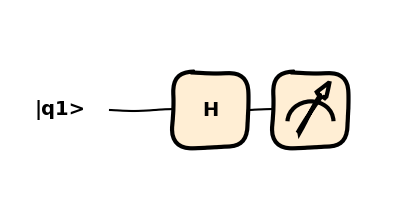

In [15]:
# sample code to draw a hadarmad gate using PennyLane
# here 
dev = qml.device("default.qubit", wires=["|q1>"])

# now simple circiut where we return the state of the qubits
@qml.qnode(dev)
def circuit():
    qml.Hadamard(wires="|q1>")
    return qml.counts(all_outcomes=True)

# plot the circuit
fig, ax = qml.draw_mpl(circuit)()

What could we expect if we measured the output of this circuit 10 times? 100 times? What happens if you do 1000 times?

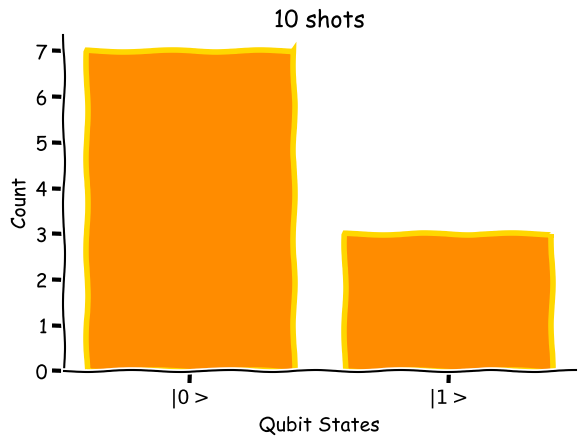

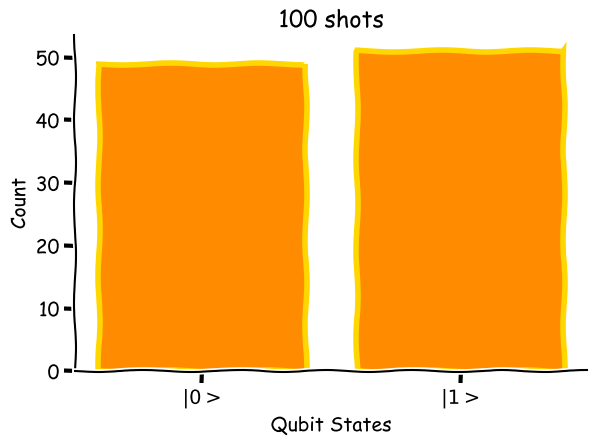

In [16]:
# lets create a quantum device that will take 10 shots
results = circuit(shots=10)
# here plot the results
PlotPennyLaneHisto(results, '10 shots')

# now you try running more shots by running the circuit again. 
results = circuit(shots=100)
# here plot the results
PlotPennyLaneHisto(results, '100 shots')

# what would you expect if you could infinitly sample the simple circuit?


### What's the "sound" of a mixed state?

To gain more understainding, let's look at using the **qmuvi** visualisation tool to see what is happening with the Hadamard gate. In a classical system, you can only have 0 or 1 but in the quantum system, while the state is not measured, it is a real mixture of 0 and 1. Let's consider a musical analogue. If we considered 0 to be a note and 1 being another then we should expect the music to start with a single note before the Hadamard gate is placed, then it should become two notes and when measured go back to one of the notes. 

Here we'll have to use Qiskit to create the circuit 

In [17]:
# c
circuit = QuantumCircuit(1)
# Barrier gates tell qMuVi where to sample the state in the circuit. It's like you are measuring the system with out truly collapsing the state
circuit.barrier()
circuit.h(0)
circuit.barrier()
# how to measure with qiskit that works with qmuvi?
#circuit.

qmuvi.generate_qmuvi(circuit, "hadamard")

Generating qMuVi data...
Generating MIDI track files...
Converting to .wav files using TiMidity++
Errors in thread 0:


CalledProcessError: Command '['/Users/ela017/software/pyvenv/lib/python3.9/site-packages/qmuvi/package_data/binaries/TiMidity-2.15.0/macos/timidity', '-Ow', '--preserve-silence', '-A,120', '--no-anti-alias', '--mod-wheel', '--portamento', '--vibrato', '--no-ch-pressure', '--mod-envelope', '--trace-text-meta', '--overlap-voice', '--default-bank=0', '--default-program=0', '--delay=d,0', '--chorus=n,64', '--reverb=f,40,0.28,0.7,100', '--voice-lpf=c', '--noise-shaping=4', '--resample=5', '--voice-queue=0', '--decay-time=0', '--interpolation=gauss', '-EFresamp=34', '--output-stereo', '--output-24bit', '--polyphony=15887', '--sampling-freq=44100', '--volume-curve=1.661', '--config-file="/Users/ela017/software/pyvenv/lib/python3.9/site-packages/qmuvi/package_data/resources/timidity/timidity.cfg"', '-o', '"/Users/ela017/myresearch/quantumcomputing/quantum-computing-hackathon/lessons/hadamard-output-3/hadamard-4.wav"', '"/Users/ela017/myresearch/quantumcomputing/quantum-computing-hackathon/lessons/hadamard-output-3/hadamard-4.mid"']' returned non-zero exit status 1.

### Playing with Hadamard's 

Try playing with this gate with the boiler plate code below. Try running more than one qubit or more than one gate per qubit. What do you see?

In [18]:
# Here is the boiler plate
dev = qml.device("default.qubit", wires=)
@qml.qnode(dev)
def circuit():
    # add your circuits here
    return qml.counts(all_outcomes=True)
# then run the circuit and plot the result. How many shots do you think you need to take to really get the ideal (true) result?
results = 
PlotPennyLaneHisto(results, '100 shots')


SyntaxError: expression cannot contain assignment, perhaps you meant "=="? (2785914221.py, line 2)

#### Interactive widget
We can also make use of an interactive tool to create and run some plots. Lets try just plotting first)

In [88]:
interact(MakeCircuit, num_qubits=widgets.IntSlider(min=1, max=30, step=1, value=2), 
         add_H=True, 
         add_CNOT = fixed(False), 
         hqubits=fixed(None))

interactive(children=(IntSlider(value=2, description='num_qubits', max=30, min=1), Checkbox(value=True, descri…

<function __main__.MakeCircuit(num_qubits: int = 1, add_H: bool = True, add_CNOT: bool = True, hqubits: list = None)>

You can even try simulating the output of a quantum computer

In [90]:
interact(MakeAndRunCircuit, 
         num_shots=widgets.IntSlider(min=10, max=10000, step=5, value=10), 
         num_qubits=widgets.IntSlider(min=1, max=30, step=1, value=2), 
         add_H=True, 
         add_CNOT = fixed(False), 
         hqubits=fixed(None))

interactive(children=(IntSlider(value=10, description='num_shots', max=10000, min=10, step=5), IntSlider(value…

<function __main__.MakeAndRunCircuit(num_shots: int = 100, num_qubits: int = 1, add_H: bool = True, add_CNOT: bool = True, hqubits: list = None)>

## Entanglement or "CNOT" Gate

Another of the simplest instructions or operations you can apply to two qubits is the *Controlled NOT (CNOT)* gate, $CNOT(\textrm{qubit}_{1}, \textrm{qubit}_{2})$ which essentially implements entanglement. It entangles two qubits so that the state of the second qubit is dependent on the state of the first. The CNOT gate flips the second qubit (the target qubit) if and only if the first qubit (the control qubit) is $\ket{1}$. So if we look at table of what happens before and after entanglement we see 

| Before       |              | | After        |              |
| ------------ | ------------ | - | ------------ | ------------ |
| Control $\ket{q_1}$ | Target $\ket{q_2}$  | $\rightarrow$ | Control $\ket{q_1}$  | Target $\ket{q_2}$  |
| $\ket{0}$    | $\ket{0}$    | $\rightarrow$ | $\ket{0}$    | $\ket{0}$    |
| $\ket{1}$    | $\ket{0}$    | $\rightarrow$ |  $\ket{1}$    | $\ket{1}$    |
| $\ket{0}$    | $\ket{1}$    | $\rightarrow$ |  $\ket{0}$    | $\ket{1}$    |
| $\ket{1}$    | $\ket{1}$    | $\rightarrow$ |  $\ket{1}$    | $\ket{0}$    |


You can view this as an a classical computers *if* statement, where you change something based on a condition, though here it is important to remember that you don't know what the outcome is till you measure the qubits. These entangled two-qubit states are sometimes referred to as *Bell* states. 

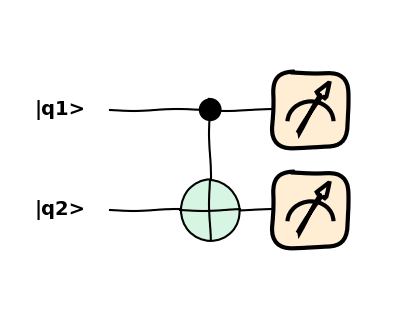

In [56]:
# sample code to draw a CNOT gate using PennyLane
# here 
dev = qml.device("default.qubit", wires=["|q1>", "|q2>"])

# now simple circiut where we return the state of the qubits
@qml.qnode(dev)
def circuit():
    # CNOT takes a list of two qubits with the first being the control and the second being the qubit being entangled.  
    qml.CNOT(["|q1>","|q2>"])
    return qml.counts(all_outcomes=True)

# plot the circuit
fig, ax = qml.draw_mpl(circuit, show_all_wires=True)()

Now this CNOT gate is not exceptionally useful on its own but combined with superposition, it can be very useful. Let's consider the following circuits where the first qubit is in superposition:

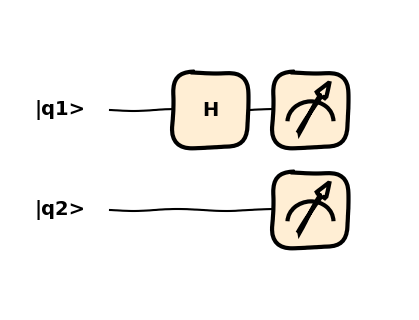

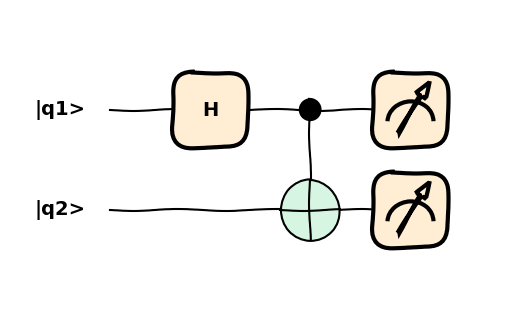

In [20]:
# sample code to draw a CNOT gate using PennyLane
dev = qml.device("default.qubit", wires=["|q1>", "|q2>"])

# now simple circiut where we return the state of the qubits
@qml.qnode(dev)
def circuit():
    qml.Hadamard(wires="|q1>")
    qml.CNOT(["|q1>","|q2>"])
    return qml.counts(all_outcomes=True)

@qml.qnode(dev)
def circuitnoCNOT():
    qml.Hadamard(wires="|q1>")
    return qml.counts(all_outcomes=True)

# plot the circuit
fig, ax = qml.draw_mpl(circuitnoCNOT, show_all_wires=True)()
fig, ax = qml.draw_mpl(circuit, show_all_wires=True)()


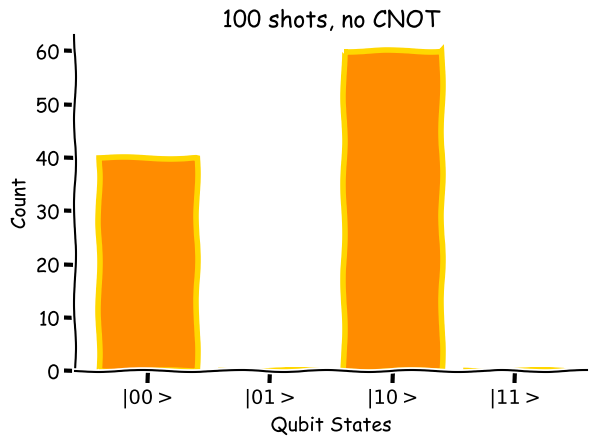

In [21]:
# lets create the quantum device and run the noCNOT circuit
dev = qml.device("default.qubit", wires=["|q1>", "|q2>"])

@qml.qnode(dev)
def circuitnoCNOT():
    qml.Hadamard(wires="|q1>")
    return qml.counts(all_outcomes=True)
results = circuitnoCNOT(shots=100)
# here plot the results
PlotPennyLaneHisto(results, '100 shots, no CNOT')

Here, we see that we get either $\ket{00}$ or $\ket{10}$ with equal probability. What do you expect to see if you have a CNOT? (discuss then try uncommenting the results)

In [26]:
# now do the same with CNOT
dev = qml.device("default.qubit", wires=["|q1>", "|q2>"])

# now simple circiut where we return the state of the qubits
@qml.qnode(dev)
def circuit():
    qml.Hadamard(wires="|q1>")
    qml.CNOT(["|q1>","|q2>"])
    return qml.counts(all_outcomes=True)

results = circuit(shots=100)
# here plot the results
# PlotPennyLaneHisto(results, '100 shots, apply CNOT')

### Playing with CNOT's 

Try playing with this gate with the boiler plate code below. Try running more than two qubits and entangling lot of them. What do you see

In [25]:
# now do the same with CNOT
dev = qml.device("default.qubit", wires=["|q1>", "|q2>", "|q3>",])

# now simple circiut where we return the state of the qubits
@qml.qnode(dev)
def circuit():
    qml.Hadamard(wires="|q1>")
    qml.CNOT(["|q1>","|q2>"])
    return qml.counts(all_outcomes=True)
# what does your circuit look like 
# fig, ax = qml.draw_mpl(circuit, show_all_wires=True)()

# lets create a quantum device that will take 100 shots
results = circuit(shots=100)
# here plot the results
# PlotPennyLaneHisto(results, 'Your experiment')

#### Interactive 
Try the interactive widget below

In [91]:
interact(MakeAndRunCircuit, 
         num_shots=widgets.IntSlider(min=10, max=10000, step=5, value=10), 
         num_qubits=widgets.IntSlider(min=1, max=30, step=1, value=2), 
         add_H=True, 
         add_CNOT = True, 
         hqubits=fixed([0]))

interactive(children=(IntSlider(value=10, description='num_shots', max=10000, min=10, step=5), IntSlider(value…

<function __main__.MakeAndRunCircuit(num_shots: int = 100, num_qubits: int = 1, add_H: bool = True, add_CNOT: bool = True, hqubits: list = None)>

## References

* Some reference